In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### **Data Loading**

In [2]:
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

170508288/170498071 [==============================] - 2s 0us/step
train dataset shape: (50000, 32, 32, 3) (50000, 1)
test dataset shape: (10000, 32, 32, 3) (10000, 1)


### **Preprocessing**
train_test_split은 이미 분리되어 있으므로 수행하지 않음

In [3]:
def preprocessed_data(images, labels):
    # 이미지 scale 및 float32 형 변형
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

def ohe_data(images, labels):
    # 라벨 원핫인코딩 적용
    images, labels = preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

In [4]:
train_images, train_labels = ohe_data(train_images, train_labels)
test_images, test_labels = ohe_data(test_images, test_labels)
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 10)


* ohe 적용을 안한 경우 label 데이터를 1차원으로 바꾸는 것이 좋음

### Modeling

In [5]:
IMAGE_SIZE = 32

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # 배치제외 3차원

x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten(name='Flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', name='fc1')(x)
x = Dropout(rate=0.3)(x)
output = Dense(train_labels.shape[1], activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

2022-03-13 03:48:07.898972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0     

2022-03-13 03:48:07.982249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 03:48:07.983036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 03:48:07.984199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-13 03:48:07.985058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(x=train_images, y=train_labels, batch_size=64, epochs=30, validation_split=0.15)

2022-03-13 03:48:37.972356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-13 03:48:39.386705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


665/665 [==============================] - 12s 7ms/step - loss: 1.6707 - accuracy: 0.3809 - val_loss: 1.3376 - val_accuracy: 0.5177
Epoch 2/30
665/665 [==============================] - 4s 7ms/step - loss: 1.2094 - accuracy: 0.5596 - val_loss: 1.0854 - val_accuracy: 0.6129
Epoch 3/30
665/665 [==============================] - 4s 6ms/step - loss: 1.0183 - accuracy: 0.6383 - val_loss: 0.9007 - val_accuracy: 0.6887
Epoch 4/30
665/665 [==============================] - 4s 6ms/step - loss: 0.8947 - accuracy: 0.6824 - val_loss: 0.8043 - val_accuracy: 0.7177
Epoch 5/30
665/665 [==============================] - 4s 6ms/step - loss: 0.7966 - accuracy: 0.7203 - val_loss: 0.7499 - val_accuracy: 0.7384
Epoch 6/30
665/665 [==============================] - 4s 6ms/step - loss: 0.7262 - accuracy: 0.7431 - val_loss: 0.7132 - val_accuracy: 0.7539
Epoch 7/30
665/665 [==============================] - 4s 7ms/step - loss: 0.6675 - accuracy: 0.7636 - val_loss: 0.6925 - val_accuracy: 0.7555
Epoch 8/30
665/6

313/313 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.8024


[0.6942450404167175, 0.8023999929428101]

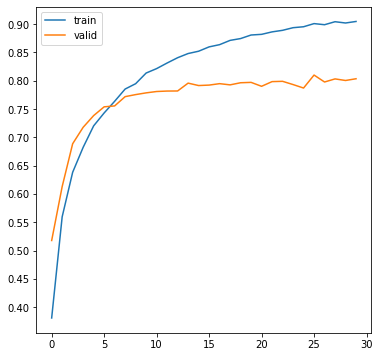

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

# 테스트 데이터로 성능 평가
model.evaluate(test_images, test_labels)